In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random

# 0 Load Data

In [2]:
t = time.time()
path  = r'/rfs/CAPAI_PhD_dflr2/Shared/Data/output/20220221_'
#file1 = path + 'admissions.txt' 
file2 = path + 'eobs.txt'
file3 = path + 'haem-results.txt'
#file4 = path + 'icu.txt'
file5 = path + 'meds.txt'
file6 = path + 'micro-results.txt'
file7 = path + 'oxygen.txt'
file8 = path + 'prev_admissions.txt'
file9 = path + 'spin.txt'
#df_admin = pd.read_csv(file1, sep='\t', lineterminator='\n')
df_eobs  = pd.read_csv(file2, sep='\t', lineterminator='\n')
df_haemt = pd.read_csv(file3, sep='\t', lineterminator='\n')
#df_icu   = pd.read_csv(file4, sep='\t', lineterminator='\n')
df_meds  = pd.read_csv(file5, sep='\t', lineterminator='\n')
df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')
df_oxyge = pd.read_csv(file7, sep='\t', lineterminator='\n')
#df_prev  = pd.read_csv(file8, sep='\t', lineterminator='\n')
df_spin  = pd.read_csv(file9, sep='\t', lineterminator='\n')

/local/dlr10/ipykernel_26267/836658027.py:17: DtypeWarning: Columns (10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')
/local/dlr10/ipykernel_26267/836658027.py:18: DtypeWarning: Columns (9,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_oxyge = pd.read_csv(file7, sep='\t', lineterminator='\n')


In [3]:
##############################################################################
#######################################
### Relevant fields for pre-processing
#######################################
reference_date = datetime.datetime(1970,1,1)

##### Fields in table patients ##########
patient_field         = 'patient_id'
age_field             = 'age_at_admission\r'
sex_field             = 'sex'
ethnic_field          = 'ethnic_origin'
death_ind_field       = 'death_indicator'
death_date_field      = 'date_of_death'
death_date_code_field = 'date_code_of_death'
mort_in_hosp_field    = 'Thirty_day_mort'
patients_cols = [patient_field,sex_field, ethnic_field, death_ind_field, death_date_field, death_date_code_field, 
                 mort_in_hosp_field]

##### Fields in table admissions ########
admission_field           = 'admission_id'
diagnosis_field           = 'episode_diagnoses'
admn_date_field           = 'admission_date_time'
admn_discharge_field      = 'discharge_date_time'
admn_date_code_field      = 'admission_date_code_time'
admn_discharge_code_field = 'discharge_date_code_time'
lengthofstay_field        = 'lengthofstay'
isPneumonia_field         = 'isPneumonia'
mortal_admin_field        = 'mortal_admin'
comorbidity_field         = 'Comorbidity_score'
icu_admin_field           = 'icu_count\r'
no_eobs_field             = 'no_obs_eobs'

 ##### Fields in table eObservations #####
eObs_time_field      = 'timestamp'
eObs_time_code_field = 'timestamp_code'
eObs_time_prev_obs   = 'time_since_prev_obs_in_mins'
eObs_resprate_field  = 'rr'
eObs_sbp_field       = 'sbp'
eObs_dbp_field       = 'dbp'
eObs_newscore_field  = 'ews'
eObs_heartrate_field = 'heart_rate'
eObs_temptr_field    = 'temperature\r'
eObs_oxygen_field    = 'Oxygen_Saturation'

In [4]:
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_2019_2020.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]

In [5]:
print('min admin date', df_admissions[admn_date_field].min(),' max admin date', df_admissions[admn_date_field].max())
print('min disch date', df_admissions[admn_discharge_field].min(),' max disch date', df_admissions[admn_discharge_field].max())
len(df_patients)

min admin date 2020-02-01 00:45:00  max admin date 2021-12-31 23:35:00
min disch date 2020-02-01 18:53:00  max disch date 2022-02-15 15:00:00


13043

In [6]:
df_eobs.head(3)

,admission_id,patient_id,timestamp,time_since_arrival_in_hosp_mins,time_since_prev_obs_in_mins,rr,bp,ews,heart_rate,temperature\r
0,9543931,80902304,2020-06-12 06:31:10,4289.0,519.0,18,170/84,0,90,37\r
1,9543931,80902304,2020-06-12 10:34:28,4532.0,243.0,18,102/67,3,111,36.4\r
2,9543931,80902304,2020-06-12 13:55:48,4733.0,201.0,18,110/68,1,86,36.2\r


In [7]:
df_eobs[eObs_time_field]      = pd.to_datetime(df_eobs[eObs_time_field], format='%Y-%m-%d %H:%M:%S')
df_eobs[eObs_time_code_field] = df_eobs[eObs_time_field] - reference_date
df_eobs[eObs_time_code_field] = df_eobs[eObs_time_code_field].apply(lambda x: x.days + (x.seconds/(24*3600)))

# 1. Processing eObs

In [8]:
t = time.time()

print("Initial number of readings in table", len(df_eobs))
df_eobs = df_eobs.drop_duplicates(keep='first')
print("Number of readings after removing duplciates",len(df_eobs))
# bp processing
bps = list(zip(*[tuple(x.split('/')) if len(tuple(x.split('/'))) == 2 else (np.nan,np.nan) for x in df_eobs['bp'].tolist()]))
df_eobs[eObs_sbp_field]       = np.array([float(x) for x in bps[0]])
df_eobs[eObs_dbp_field]       = np.array([float(x) for x in bps[1]])
# Heart rate processing
df_eobs[eObs_heartrate_field] = df_eobs[eObs_heartrate_field].apply(lambda x:float(x.replace('\r','')) if len(x.replace('\r',''))<5 else np.nan )
# Temperature processing
df_eobs[eObs_temptr_field]    = df_eobs[eObs_temptr_field].apply(lambda x: float(x.replace('\r','')) if len(x.replace('\r',''))<5 else np.nan)
df_eobs = df_eobs.drop(columns = ['time_since_arrival_in_hosp_mins','bp'])
print('')
print('time elapsed: ', time.time() - t)
df_eobs.dtypes

Initial number of readings in table 1435125
Number of readings after removing duplciates 1435125

time elapsed:  7.022720098495483


admission_id                            int64
patient_id                              int64
timestamp                      datetime64[ns]
time_since_prev_obs_in_mins           float64
rr                                      int64
ews                                     int64
heart_rate                            float64
temperature\r                         float64
timestamp_code                        float64
sbp                                   float64
dbp                                   float64
dtype: object

In [9]:
# Delete all the admissions and patients that do not have information in eObs

A= df_eobs[admission_field].unique().tolist()
print('Number of total admissions in eObs table', len(A))
list_admissions = df_admissions[admission_field].unique().tolist()
print('Number of total admissions in admissions table',len(list_admissions))
C = list(set(A) & set(list_admissions))
print('Number of total admissions in eObs and admissions tables',len(C))
print('')

#Redefinition of admissions table
df_admissions = df_admissions[df_admissions[admission_field].isin(C)].copy()
#Redefinition of list_admissions
list_admissions = df_admissions[admission_field].unique().tolist()
print('NEW number of total admissions in admissions table',len(list_admissions))
print('')

#Redefinition of patients table
df_patients = df_patients[df_patients[patient_field].isin(df_admissions[patient_field].unique())]
print('NEW number of total patients in admissions table',len(df_admissions[patient_field].unique().tolist()))
print('NEW number of total patients in patients table',len(df_patients[patient_field].unique().tolist()))

Number of total admissions in eObs table 24241
Number of total admissions in admissions table 15001
Number of total admissions in eObs and admissions tables 14714

NEW number of total admissions in admissions table 14714

NEW number of total patients in admissions table 12807
NEW number of total patients in patients table 12807


In [10]:
##################################
# Sorting the eObs set by time
t = time.time()
df_eobs_new = pd.DataFrame()
df_eobs[eObs_time_field] = pd.to_datetime(df_eobs[eObs_time_field], format='%Y-%m-%d %H:%M:%S')
for k, admission in enumerate(list_admissions):
    df_new_temp = df_eobs[df_eobs[admission_field] == admission].sort_values(by= eObs_time_field)
    df_new_temp.at[df_new_temp.index[0],eObs_time_prev_obs] = 0
    for i in range(1, len(df_new_temp)):
        df_new_temp.at[df_new_temp.index[i],eObs_time_prev_obs] = df_new_temp.iloc[i][eObs_time_field] - df_new_temp.iloc[i-1][eObs_time_field]
    df_eobs_new = pd.concat([df_eobs_new, df_new_temp])    
print('elapsed: ', time.time()-t)   

elapsed:  690.0055525302887


In [11]:
len(df_eobs_new)

890914


# 2. Processing Oxygen Table

merging all the oxygen saturation values in the same column and then adding this column to eObs table

### 2.1. Process Oxygen table

In [12]:
A = df_oxyge[admission_field].unique().tolist()
print('Number of total admissions in Oxygen table', len(A))

print('Number of total admissions in admissions table',len(list_admissions))
C = list(set(A) & set(list_admissions))
print('Number of total admissions in oxyge and admissions tables',len(C))
print('')
B = df_eobs_new[admission_field].unique().tolist()
print('Number of total admissions in eObs table', len(B))

Number of total admissions in Oxygen table 24253
Number of total admissions in admissions table 14714
Number of total admissions in oxyge and admissions tables 14714

Number of total admissions in eObs table 14714


In [13]:
display(df_oxyge.groupby(['oxygen_device']).size())
df_oxyge['Assisted_O2'] = df_oxyge['oxygen_device'].apply(lambda x: 0 if x == 'Air' else 1)
display(df_oxyge.groupby(['Assisted_O2']).size())
df_oxyge.head(3)

oxygen_device
Air                          761010
CPAP                          28880
CPAP/NIPPV                      565
Cold Humidification           19471
Face Mask Type Device            51
High Flow                     20516
Nasal Cannula Type Device        64
Nasal Optiflow                 8980
Nasal Specs                  398431
Nebuliser                      3951
Non Breathable Mask              16
Non ReBreathe Mask            21520
Non invasive Ventilation      15255
None                            177
Not Applicable                   49
Oxygen Mask                     170
Reservoir mask                 1703
Tracheostomy Mask              3330
Venturi Mask                 119242
Warm Humidification            1467
dtype: int64

Assisted_O2
0    761010
1    643838
dtype: int64

,admission_id,patient_id,timestamp,oxygen_device,inspired_o2,inspired_o2_units,o2_sats,o2_sats_units,o2_saturations,o2_saturations_units,spo2,spo2_units,receiving_o2,receiving_o2_units,cap_refill\r,Assisted_O2
0,47391074,55474654,2022-01-06 07:11:24,Air,Air,NaN,96,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,0
1,13028561,69744938,2022-01-06 07:41:35,Nasal Specs,2,litres,96,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,1
2,73353759,67438010,2022-01-06 10:45:17,Air,Air,NaN,93,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,0


### 2.2. Merge the information in 02_saturation and 02_stats columns

In [14]:
the_nulls = df_oxyge['o2_saturations'].isnull().sum()
the_fills = df_oxyge['o2_saturations'].notnull().sum()
print('Oxygen table has', len(df_oxyge), 'rows')
print("")
print('o2_saturations')
print('In o2_saturations are', the_fills, 'not null values')
print('In o2_saturations are', the_nulls, 'null values')
print(the_fills, '+',the_nulls,'=', the_nulls+the_fills)
the_nulls = df_oxyge['o2_sats'].isnull().sum()
the_fills = df_oxyge['o2_sats'].notnull().sum()
print("")
print('o2_sats')
print('In o2_sats are', the_fills, 'not null values')
print('In o2_sats are', the_nulls, 'null values')
print(the_fills, '+',the_nulls,'=', the_nulls+the_fills)

Oxygen table has 1404848 rows

o2_saturations
In o2_saturations are 292 not null values
In o2_saturations are 1404556 null values
292 + 1404556 = 1404848

o2_sats
In o2_sats are 1384720 not null values
In o2_sats are 20128 null values
1384720 + 20128 = 1404848


In [15]:
# Merging both columns and changing to dtypes int
def cleaning_saturation_data(item):
    
    if (type(item) == int) or (type(item) == float) : new_value = item
    elif (type(item) == str)  and (item.strip().isnumeric()): new_value = int(item)
    elif (type(item) == str)  and any(x.isnumeric() for x in item):
        if re.search(r'[0-9]{,4}\-[0-9]{,4}', item):
            o2_range = re.search(r'[0-9]{,4}\-[0-9]{,4}', item).group(0)
            o2_range = [int(x) for x in o2_range.split('-')]
            new_value = np.array(o2_range).mean()
    else:
        new_value = np.nan
    return new_value    

df_oxyge['o2_sats_']        = df_oxyge['o2_sats'].apply(lambda x: cleaning_saturation_data(x))
df_oxyge['o2_saturations_'] = df_oxyge['o2_saturations'].apply(lambda x: cleaning_saturation_data(x))
df_oxyge[eObs_oxygen_field]      = df_oxyge.filter(['o2_sats_','o2_saturations_']).max(1)
print('total values that are null', df_oxyge[eObs_oxygen_field].isnull().sum(), ',values to be imputed')
print('values in Oxygen table', len(df_oxyge))
print('values in eobs', len(df_eobs))
display(df_oxyge.head(2))

total values that are null 29294 ,values to be imputed
values in Oxygen table 1404848
values in eobs 1435125


,admission_id,patient_id,timestamp,oxygen_device,inspired_o2,inspired_o2_units,o2_sats,o2_sats_units,o2_saturations,o2_saturations_units,spo2,spo2_units,receiving_o2,receiving_o2_units,cap_refill\r,Assisted_O2,o2_sats_,o2_saturations_,Oxygen_Saturation
0,47391074,55474654,2022-01-06 07:11:24,Air,Air,NaN,96,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,0,96.0,NaN,96.0
1,13028561,69744938,2022-01-06 07:41:35,Nasal Specs,2,litres,96,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,1,96.0,NaN,96.0


In [16]:
##################################
# Sorting the eObs set by time, getting the information 
t = time.time()
df_oxyge_new = pd.DataFrame()
df_oxyge[eObs_time_field] = pd.to_datetime(df_oxyge[eObs_time_field], format='%Y-%m-%d %H:%M:%S')

for k, admission in enumerate(list_admissions):
    df_new_temp = df_oxyge[df_oxyge[admission_field] == admission].sort_values(by= eObs_time_field)
    df_oxyge_new = pd.concat([df_oxyge_new, df_new_temp])    
print('elapsed: ', time.time()-t)   

elapsed:  712.6031177043915


In [17]:
A = df_oxyge_new[admission_field].unique().tolist()
print('Number of total admissions in Oxygen table', len(A))

print('Number of total admissions in admissions table',len(list_admissions))
C = list(set(A) & set(list_admissions))
print('Number of total admissions in oxyge and admissions tables',len(C))
print('')
B = df_eobs_new[admission_field].unique().tolist()
print('Number of total admissions in eObs table', len(B))

Number of total admissions in Oxygen table 14714
Number of total admissions in admissions table 14714
Number of total admissions in oxyge and admissions tables 14714

Number of total admissions in eObs table 14714


# 3. Check and handle Outliers

In [18]:
df_eobs_new.describe()

,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,8.909140e+05,8.909140e+05,890914.000000,890914.000000,885925.000000,879661.000000,890914.000000,881207.000000,881207.000000
mean,4.987276e+07,4.980925e+07,19.182653,2.519044,83.511564,36.814105,18654.037054,124.094196,71.004660
std,2.853921e+07,2.879662e+07,3.597374,2.307328,16.560714,0.633398,198.331833,20.774340,13.930231
min,7.126000e+03,9.430000e+02,1.000000,0.000000,10.000000,28.200000,18293.002106,35.000000,0.000000
25%,2.533935e+07,2.451986e+07,18.000000,1.000000,72.000000,36.400000,18497.906751,110.000000,62.000000
50%,4.951649e+07,4.989089e+07,18.000000,2.000000,83.000000,36.700000,18649.843218,122.000000,70.000000
75%,7.434628e+07,7.454422e+07,20.000000,4.000000,93.000000,37.100000,18827.609089,137.000000,79.000000
max,9.999534e+07,9.999676e+07,98.000000,20.000000,295.000000,42.000000,19038.549792,299.000000,242.000000


In [19]:
df_eobs_new.isna().sum()

admission_id                       0
patient_id                         0
timestamp                          0
time_since_prev_obs_in_mins        0
rr                                 0
ews                                0
heart_rate                      4989
temperature\r                  11253
timestamp_code                     0
sbp                             9707
dbp                             9707
dtype: int64

In [20]:
dict_labels = {'rr':'Respiratory rate','ews':'EWS','heart_rate':'Heart rate','temperature\r':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation','Assisted_O2':'Assisted O2',
               'Confusion':'Confusion','CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR','WBC':'WBC',
               'PLT':'Platelets','HCT':'HCT','HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab',
               'TLYMAB':'T-lymphocite Ab','EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin','sex':'Sex','ethnicity':'Ethnicity','had_Prev_admin':'Prev. admission',
               'age_at_admin':'Age at admission','Comorb_score':'Charlson comorbid.','Spcfc_Comorb':'Resp. Comorbidity'}

dict_sypmt_min_max = {'rr':[5, 40], 'heart_rate':[20,160], 'temperature\r':[30, 45],'sbp': [60,200], 'dbp':[40,120],
                 'Oxygen_Saturation':[60,100], 'ews':[0,21]}

In [43]:
import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

def handling_errors(field, df_eobs_new,dict_sypmt_min_max, save = False):
    n_plots = 4
    print(field)
    print("Values na in " + field,df_eobs_new[field].isna().sum())
    min_b = dict_sypmt_min_max[field][0]
    max_b = dict_sypmt_min_max[field][1]
    adm_withmin = df_eobs_new[min_b > df_eobs_new[field]]['admission_id'].unique().tolist()
    adm_withmax = df_eobs_new[df_eobs_new[field] > max_b]['admission_id'].unique().tolist()
    adms_plot   = adm_withmin + adm_withmax
    
    field_max = df_eobs_new[field].max()
    n_outliers = len(df_eobs_new[(min_b > df_eobs_new[field]) | (df_eobs_new[field] > max_b)])
    
    
    print('Number of admissions that will change:', len(adms_plot) )    
    print('Number of records out of limits:', n_outliers)
    
    if len(adms_plot) == 0 : 
        print("No values to fix")
        return df_eobs_new
    if len(adms_plot) <= n_plots: adm_idxs    = range(len(adms_plot))
    else:                   adm_idxs    = random.sample(range(len(adms_plot)), n_plots)

    df_eobs_new2 = df_eobs_new.copy()
    df_eobs_new2[field] = df_eobs_new2[field].apply(lambda x: np.nan if x!=x else x if (min_b <= x) and (x <= max_b) 
                                                    else min_b if x < min_b else max_b)
    n_outliers2 = len(df_eobs_new2[(min_b > df_eobs_new2[field]) | (df_eobs_new2[field] > max_b)])
    
    print("Percentage of admins modified for " + field, "from", len(df_eobs_new2['admission_id'].unique()), 
          "is {:0.2f}".format(len(adms_plot)*100/len(df_eobs_new2['admission_id'].unique())), "%")
    print("Percentage of records modified for " + field, "from", len(df_eobs_new2), 
          "is {:0.2f}".format(n_outliers*100/len(df_eobs_new2)), "%")

    fig = plt.figure(figsize = (25,5))

    for i,idx_adm in enumerate(adm_idxs):
        adm_ = adms_plot[idx_adm]    
        x = df_eobs_new[df_eobs_new[admission_field] == adm_]['timestamp'].tolist()
        x1 = np.arange(0, len(x), 1)
        y = df_eobs_new[df_eobs_new[admission_field] == adm_][field]

        xt = df_eobs_new2[df_eobs_new2[admission_field] == adm_]['timestamp']
        xt1 = np.arange(0, len(xt), 1)
        yt = df_eobs_new2[df_eobs_new2[admission_field] == adm_][field]

        ax = fig.add_subplot(1, n_plots, i+1)
        ax.plot(x1,y, 'b-.', label = 'Original')
        ax.plot(xt1,yt, 'r-', label = 'Processed')
        
        ax.plot(x1, np.ones(len(x1)) * max_b, '--', color = 'orange')
        ax.plot(x1, np.ones(len(x1)) * min_b, '--', color = 'orange')
        
        ax.tick_params(labelsize =22)
        ax.set_ylim((min_b *0.75,max_b +  (field_max-max_b)*0.3))
        ax.set_title('admission ' + str(adm_), fontsize = 25)
        
    fig.text(0.08, 0.5, dict_labels[field], va='center', rotation='vertical', fontsize = 30)
    plt.legend(fontsize = 20, loc = 'upper right', frameon=False, framealpha = 0.4)
    if save == True: 
        plt.savefig(r'Images/Valid_HandlingOutliersExample_'+ field +'.png', transparent = True, bbox_inches = "tight")
    plt.show()
    return df_eobs_new2

### Handle Outliers of Eobs

rr
Values na in rr 0
Number of admissions that will change: 841
Number of records out of limits: 2270
Percentage of admins modified for rr from 14714 is 5.72 %
Percentage of records modified for rr from 890914 is 0.25 %


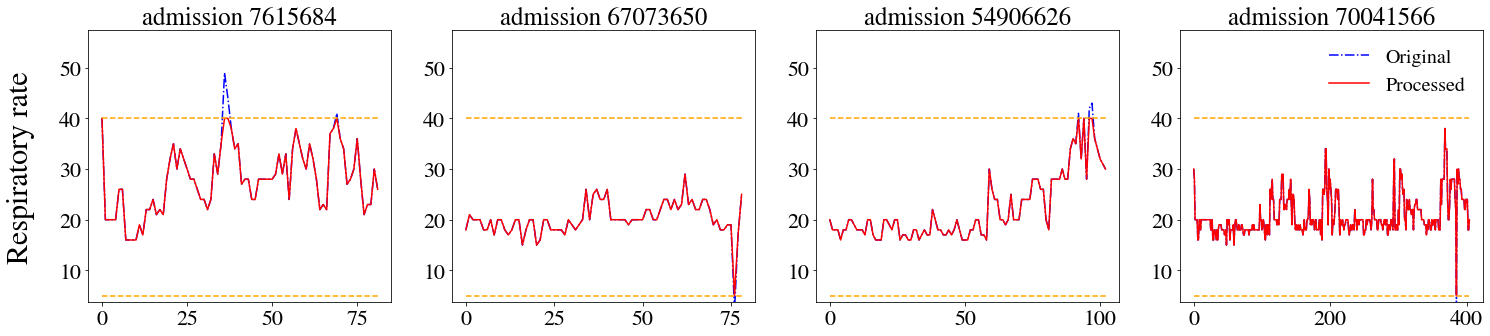

In [44]:
df_eobs_new2 = handling_errors('rr', df_eobs_new, dict_sypmt_min_max, save = True)

In [45]:
df_eobs_new2 = handling_errors('ews', df_eobs_new2, dict_sypmt_min_max, save = True)

ews
Values na in ews 0
Number of admissions that will change: 0
Number of records out of limits: 0
No values to fix


heart_rate
Values na in heart_rate 4989
Number of admissions that will change: 322
Number of records out of limits: 665
Percentage of admins modified for heart_rate from 14714 is 2.19 %
Percentage of records modified for heart_rate from 890914 is 0.07 %


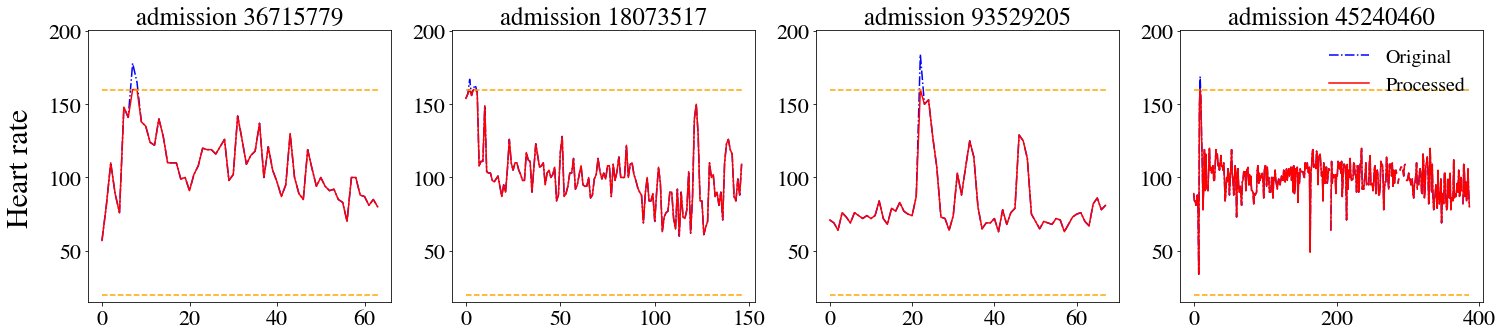

In [46]:
df_eobs_new2 = handling_errors('heart_rate', df_eobs_new2, dict_sypmt_min_max, save = True)

temperature
 11253 na in temperature
Number of admissions that will change: 14
Number of records out of limits: 23
 from 14714 is 0.10 %modified for temperature
 from 890914 is 0.00 %modified for temperature


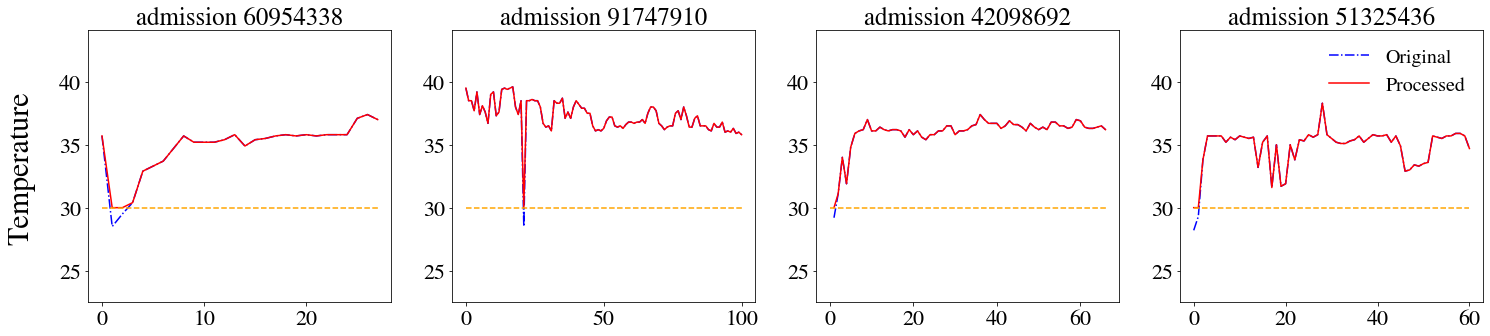

In [47]:
df_eobs_new2 = handling_errors('temperature\r', df_eobs_new2, dict_sypmt_min_max, save = True)

sbp
Values na in sbp 9707
Number of admissions that will change: 805
Number of records out of limits: 1458
Percentage of admins modified for sbp from 14714 is 5.47 %
Percentage of records modified for sbp from 890914 is 0.16 %


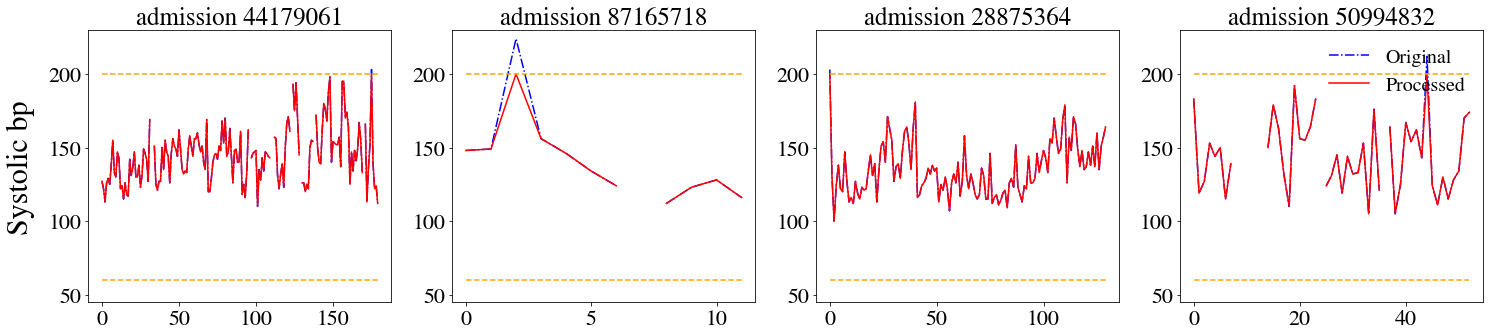

In [48]:
df_eobs_new2 = handling_errors('sbp', df_eobs_new2, dict_sypmt_min_max, save = True)

dbp
Values na in dbp 9707
Number of admissions that will change: 5834
Number of records out of limits: 10386
Percentage of admins modified for dbp from 14714 is 39.65 %
Percentage of records modified for dbp from 890914 is 1.17 %


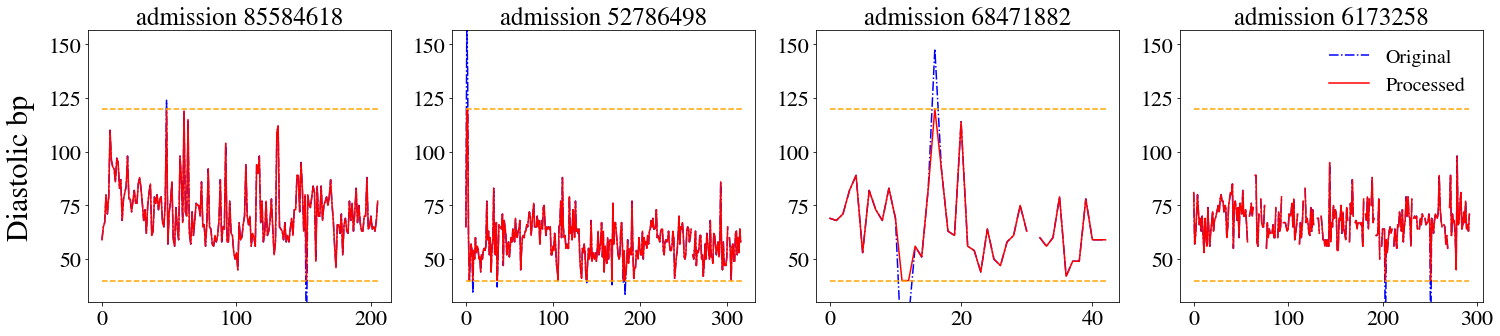

In [49]:
df_eobs_new2 = handling_errors('dbp', df_eobs_new2, dict_sypmt_min_max, save = True)

In [28]:
display(df_eobs_new.describe())
display(df_eobs_new2.describe())

,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,8.909140e+05,8.909140e+05,890914.000000,890914.000000,885925.000000,879661.000000,890914.000000,881207.000000,881207.000000
mean,4.987276e+07,4.980925e+07,19.182653,2.519044,83.511564,36.814105,18654.037054,124.094196,71.004660
std,2.853921e+07,2.879662e+07,3.597374,2.307328,16.560714,0.633398,198.331833,20.774340,13.930231
min,7.126000e+03,9.430000e+02,1.000000,0.000000,10.000000,28.200000,18293.002106,35.000000,0.000000
25%,2.533935e+07,2.451986e+07,18.000000,1.000000,72.000000,36.400000,18497.906751,110.000000,62.000000
50%,4.951649e+07,4.989089e+07,18.000000,2.000000,83.000000,36.700000,18649.843218,122.000000,70.000000
75%,7.434628e+07,7.454422e+07,20.000000,4.000000,93.000000,37.100000,18827.609089,137.000000,79.000000
max,9.999534e+07,9.999676e+07,98.000000,20.000000,295.000000,42.000000,19038.549792,299.000000,242.000000


,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,8.909140e+05,8.909140e+05,890914.000000,890914.000000,885925.000000,879661.000000,890914.000000,881207.000000,881207.000000
mean,4.987276e+07,4.980925e+07,19.167129,2.519044,83.501172,36.814128,18654.037054,124.079595,71.109659
std,2.853921e+07,2.879662e+07,3.469745,2.307328,16.500637,0.633129,198.331833,20.701638,13.169059
min,7.126000e+03,9.430000e+02,5.000000,0.000000,20.000000,30.000000,18293.002106,60.000000,40.000000
25%,2.533935e+07,2.451986e+07,18.000000,1.000000,72.000000,36.400000,18497.906751,110.000000,62.000000
50%,4.951649e+07,4.989089e+07,18.000000,2.000000,83.000000,36.700000,18649.843218,122.000000,70.000000
75%,7.434628e+07,7.454422e+07,20.000000,4.000000,93.000000,37.100000,18827.609089,137.000000,79.000000
max,9.999534e+07,9.999676e+07,40.000000,20.000000,160.000000,42.000000,19038.549792,200.000000,120.000000


### Handle Outliers of Oxygen df

Oxygen_Saturation
Values na in Oxygen_Saturation 6062
Number of admissions that will change: 313
Number of records out of limits: 460
Percentage of admins modified for Oxygen_Saturation from 14714 is 2.13 %
Percentage of records modified for Oxygen_Saturation from 865029 is 0.05 %


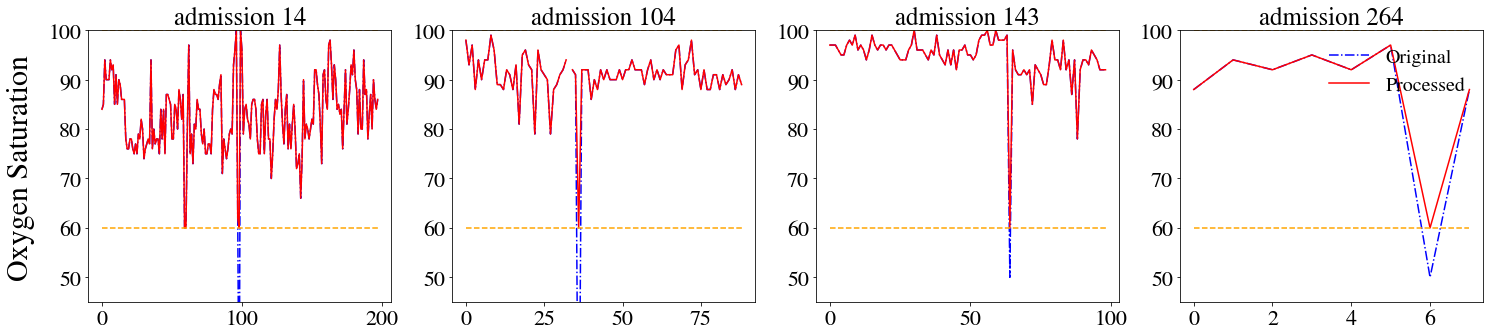

In [30]:
df_oxyge_new2 = handling_errors('Oxygen_Saturation', df_oxyge_new, dict_sypmt_min_max, save = True)

In [31]:
display(df_oxyge_new.describe())
display(df_oxyge_new2.describe())

,admission_id,patient_id,o2_saturations,spo2,spo2_units,Assisted_O2,o2_sats_,o2_saturations_,Oxygen_Saturation
count,8.650290e+05,8.650290e+05,8.000000,0.0,0.0,865029.000000,858959.000000,8.000000,858967.000000
mean,4.990335e+07,4.991540e+07,97.000000,NaN,NaN,0.488803,95.396934,97.000000,95.396949
std,2.857686e+07,2.877179e+07,1.511858,NaN,NaN,0.499875,3.481510,1.511858,3.481499
min,7.126000e+03,9.430000e+02,94.000000,NaN,NaN,0.000000,0.000000,94.000000,0.000000
25%,2.543153e+07,2.484751e+07,96.750000,NaN,NaN,0.000000,94.000000,96.750000,94.000000
50%,4.944586e+07,4.998739e+07,97.000000,NaN,NaN,0.000000,96.000000,97.000000,96.000000
75%,7.444571e+07,7.471907e+07,98.000000,NaN,NaN,1.000000,97.000000,98.000000,97.000000
max,9.999534e+07,9.999676e+07,99.000000,NaN,NaN,1.000000,100.000000,99.000000,100.000000


,admission_id,patient_id,o2_saturations,spo2,spo2_units,Assisted_O2,o2_sats_,o2_saturations_,Oxygen_Saturation
count,8.650290e+05,8.650290e+05,8.000000,0.0,0.0,865029.000000,858959.000000,8.000000,858967.000000
mean,4.990335e+07,4.991540e+07,97.000000,NaN,NaN,0.488803,95.396934,97.000000,95.415063
std,2.857686e+07,2.877179e+07,1.511858,NaN,NaN,0.499875,3.481510,1.511858,3.155104
min,7.126000e+03,9.430000e+02,94.000000,NaN,NaN,0.000000,0.000000,94.000000,60.000000
25%,2.543153e+07,2.484751e+07,96.750000,NaN,NaN,0.000000,94.000000,96.750000,94.000000
50%,4.944586e+07,4.998739e+07,97.000000,NaN,NaN,0.000000,96.000000,97.000000,96.000000
75%,7.444571e+07,7.471907e+07,98.000000,NaN,NaN,1.000000,97.000000,98.000000,97.000000
max,9.999534e+07,9.999676e+07,99.000000,NaN,NaN,1.000000,100.000000,99.000000,100.000000


# 4. Modification of Admissions DataFrame

### 4.1. Adding Number of e-observation to each admission

In [32]:
t = time.time()
admin_obs = []
for adm in df_admissions[admission_field]:    
    admin_obs.append(len(df_eobs_new2[df_eobs_new2[admission_field] == adm]))

df_admissions.at[:,[no_eobs_field]] = admin_obs

print('times elapsed: ',time.time() - t)
df_admissions.head(3)

times elapsed:  13.448374032974243


,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs
3,99645131,"||E10.5,L97.X,L08.9,R02.X,A41.9,R65.1,N17.9,E1...",18026138,55,2021-11-25 16:34:00,18956.690278,2021-12-31 14:48:00,18992.616667,35 days 22:14:00,1,0,0,2,169
4,21362780,"||U07.1,J12.8,B97.2,J15.9,B97.2,Z86.7||U07.1,J...",27754209,45,2021-11-12 17:21:00,18943.722917,2021-11-20 14:00:00,18951.583333,7 days 20:39:00,1,0,0,0,42
5,13991116,"||A41.9,U07.1,J12.8,B97.2,K75.0,K92.0,J90.X,I8...",54047888,70,2020-04-20 21:48:00,18372.908333,2020-05-20 05:30:00,18402.229167,29 days 07:42:00,1,1,0,1,210


In [33]:
df_admissions.describe()

,admission_id,patient_id,age_at_admission\r,admission_date_code_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs
count,1.471400e+04,1.471400e+04,14714.000000,14714.000000,14714.000000,14714,14714.0,14714.000000,14714.000000,14714.000000,14714.000000
mean,4.996643e+07,5.030565e+07,68.645168,18638.458705,18650.519506,12 days 01:27:33.176566535,1.0,0.237665,0.036972,4.625323,60.548729
std,2.873749e+07,2.880142e+07,17.550267,200.654471,201.425417,15 days 03:14:13.666732312,0.0,0.425667,0.188698,7.358791,69.475114
min,7.126000e+03,9.430000e+02,16.000000,18293.031250,18293.786806,0 days 00:02:00,1.0,0.000000,0.000000,0.000000,1.000000
25%,2.517495e+07,2.505592e+07,57.000000,18470.490278,18482.633681,3 days 21:06:15,1.0,0.000000,0.000000,0.000000,23.000000
50%,4.982885e+07,5.058154e+07,72.000000,18637.936111,18649.576389,7 days 21:59:00,1.0,0.000000,0.000000,2.000000,42.000000
75%,7.481905e+07,7.518599e+07,83.000000,18814.497569,18827.791667,14 days 22:04:00,1.0,0.000000,0.000000,6.000000,75.000000
max,9.999534e+07,9.999676e+07,104.000000,18992.982639,19038.625000,355 days 08:15:00,1.0,1.000000,1.000000,258.000000,1538.000000


In [34]:
df_admissions[df_admissions['no_obs_eobs']> 1200]

,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs
2634,31152038,"||C81.7 D,G13.0 A,E86.X,R18.X,J90.X,A41.8,D70....",24234939,48,2021-04-23 19:43:00,18740.821528,2021-11-15 17:35:00,18946.732639,205 days 21:52:00,1,1,0,4,1538
12976,92526834,"||D13.6,A41.5,Q44.5,K66.0,K65.9,K63.2,K85.9,T8...",94834343,73,2020-05-14 07:15:00,18396.302083,2021-05-04 15:30:00,18751.645833,355 days 08:15:00,1,0,0,0,1527
14791,49748372,"||D43.2,U07.1,J12.8,B97.2,Y95.X,Z29.0,Z98.2,J1...",53335247,55,2021-01-29 10:15:00,18656.427083,2021-10-08 16:00:00,18908.666667,252 days 05:45:00,1,0,0,1,1531
21722,52631952,"||I71.2,Y83.1,A41.9,D64.9,I25.1,I10.X,E66.9,Z9...",10251479,62,2021-03-25 03:17:00,18711.136806,2021-12-31 02:00:00,18992.083333,280 days 22:43:00,1,1,1,30,1261


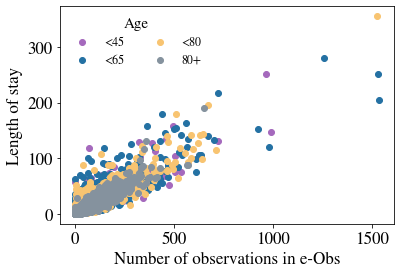

In [41]:
df_plot = df_admissions[['age_at_admission\r', 'lengthofstay', 'no_obs_eobs']].copy()
df_plot['age_group'] = df_plot['age_at_admission\r'].apply(lambda x: 0 if x < 45 else 1 if x < 65 else 2 if x < 80 else 3)

plt.scatter(df_plot[df_plot['age_group'] == 0]['no_obs_eobs'], df_plot[df_plot['age_group'] == 0]['lengthofstay'].dt.days, label = '<45', color = '#a569bd')
plt.scatter(df_plot[df_plot['age_group'] == 1]['no_obs_eobs'], df_plot[df_plot['age_group'] == 1]['lengthofstay'].dt.days, label = '<65', color = '#2471a3')
plt.scatter(df_plot[df_plot['age_group'] == 2]['no_obs_eobs'], df_plot[df_plot['age_group'] == 2]['lengthofstay'].dt.days, label = '<80', color = '#f8c471')
plt.scatter(df_plot[df_plot['age_group'] == 3]['no_obs_eobs'], df_plot[df_plot['age_group'] == 3]['lengthofstay'].dt.days, label = '80+', color = '#85929e')
plt.xlabel('Number of observations in e-Obs', fontsize = 17)
plt.ylabel('Length of stay', fontsize = 17)
plt.tick_params(labelsize = 17)
plt.legend( title = 'Age', title_fontsize = 15, fontsize = 12, frameon=False, framealpha = 0.4, ncol = 2)
plt.savefig(r'Images/LoS_NumbereObs.png', transparent = True, bbox_inches = "tight")
plt.show()

### 4.2. Processing Ethnicity field to make it a numerical variable

In [36]:
A = df_patients[ethnic_field].unique().tolist()
print(A)
df_patients.loc[:,ethnic_field] = df_patients[ethnic_field].apply(lambda x: A.index(x))
print(df_patients[ethnic_field].unique().tolist())

['A', 'H', 'S', 'L', 'Z', 'M', 'B', 'P', 'C', 'K', 'J', 'G', 'N', 'D', 'F', 'E', 'R']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


/local/dlr10/ipykernel_26267/2537763513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patients.loc[:,ethnic_field] = df_patients[ethnic_field].apply(lambda x: A.index(x))


# 5. Pickle data

In [37]:
display(df_eobs_new2.head(2))
display(df_oxyge_new2.head(2))

,admission_id,patient_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
286091,99645131,18026138,2021-11-25 09:04:56,0.0,20,0,85.0,36.1,18956.378426,166.0,69.0
286094,99645131,18026138,2021-11-25 11:13:23,0 days 02:08:27,19,1,82.0,36.0,18956.467627,189.0,58.0


,admission_id,patient_id,timestamp,oxygen_device,inspired_o2,inspired_o2_units,o2_sats,o2_sats_units,o2_saturations,o2_saturations_units,spo2,spo2_units,receiving_o2,receiving_o2_units,cap_refill\r,Assisted_O2,o2_sats_,o2_saturations_,Oxygen_Saturation
282023,99645131,18026138,2021-11-25 09:04:56,Air,Air,NaN,100,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,0,100.0,NaN,100.0
282037,99645131,18026138,2021-11-25 11:13:23,Air,Air,NaN,97,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,0,97.0,NaN,97.0


In [38]:

pickling_data = [df_patients, df_admissions]
pickle.dump(pickling_data, open('DataFrame_pickles/df_patients_admissions_2019_2020_v2.pickle', 'wb'))
pickling_data = [df_eobs_new2, df_oxyge_new2]
pickle.dump(pickling_data, open('DataFrame_pickles/df_eobs_oxygen_2019_2020_v2.pickle', 'wb'))

# Adding the Curb Field column

Adding curb 65 information from table spin to eObs table

In [39]:
print('number of patients in spin', len(df_spin[patient_field].unique().tolist()))
print('number of patients in patients', len(df_patients))
c = len(list(set(df_spin[patient_field].unique().tolist()) & set(df_patients[patient_field])))
print('number of patients in spin and patients', c)

df_spin.head(3)


number of patients in spin 6031
number of patients in patients 12807
number of patients in spin and patients 3270


,patient_id,date_time_arrived,cxr_4h,cxr_cap,cxr_date,cxr_time,o2_1h,o2_prescribed_1h,curb65_recorded,curb65_score,ab_4h,reason_ab_not_concordant,ab_severity,ab_date_time\r
0,45502669,2019-01-02 15:46:00,Y,Y,2019-01-02,16:14,Y,N,Y,0.0,Y,NaN,Y,2019-01-02 17:00:00\r
1,70844377,2019-01-03 11:47:00,N,Y,2018-12-31,11:54,Y,N,Y,0.0,Y,2.0,Y,2019-01-03 14:00:00\r
2,43194461,2019-01-02 10:15:00,Y,Y,2019-01-02,10:31,Y,N,Y,0.0,Y,2.0,Y,2019-01-02 12:20:00\r
